In [7]:
from __future__ import division, print_function
import os
import sys
import pickle

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

import renom as rm
from renom.optimizer import Sgd, Adam
from renom.cuda.cuda import set_cuda_active

In [8]:
set_cuda_active(False)

In [9]:
dir = "./cifar-10-batches-py/"
paths = ["data_batch_1", "data_batch_2", "data_batch_3",
         "data_batch_4", "data_batch_5"]

def unpickle(f):
    fo = open(f, 'rb')
    if sys.version_info.major == 2:
        # Python 2.7
        d = pickle.load(fo)
    elif sys.version_info.major == 3:
        # Python 3.4
        d = pickle.load(fo, encoding="latin-1")
    fo.close()
    return d

# Load train data.
data = list(map(unpickle, [os.path.join(dir, p) for p in paths]))
train_x = np.vstack([d["data"] for d in data])
train_y = np.vstack([d["labels"] for d in data])

# Load test data.
data = unpickle(os.path.join(dir, "test_batch"))
test_x = np.array(data["data"])
test_y = np.array(data["labels"])

# Rehsape and rescale image.
train_x = train_x.reshape(-1, 3, 32, 32)
train_y = train_y.reshape(-1, 1)
test_x = test_x.reshape(-1, 3, 32, 32)
test_y = test_y.reshape(-1, 1)

train_x = train_x / 255.
test_x = test_x / 255.

# Binalize
labels_train = LabelBinarizer().fit_transform(train_y)
labels_test = LabelBinarizer().fit_transform(test_y)

# Change types.
train_x = train_x.astype(np.float32)
test_x = test_x.astype(np.float32)
labels_train = labels_train.astype(np.float32)
labels_test = labels_test.astype(np.float32)

N = len(train_x)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


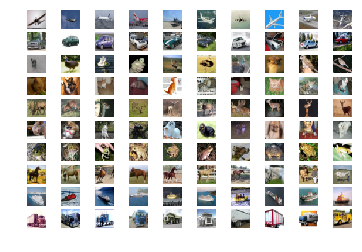

In [10]:
# ラベル名をロード
label_names = unpickle("cifar-10-batches-py/batches.meta")["label_names"]
d = unpickle("cifar-10-batches-py/data_batch_1")
data = d["data"]
labels = np.array(d["labels"])
nsamples = len(data)

print(label_names)

# 各クラスの画像をランダムに10枚抽出して描画
nclasses = 10
pos = 1
for i in range(nclasses):
    # クラスiの画像のインデックスリストを取得
    targets = np.where(labels == i)[0]
    np.random.shuffle(targets)
    # 最初の10枚の画像を描画
    for idx in targets[:10]:
        plt.subplot(10, 10, pos)
        img = data[idx]
        # (channel, row, column) => (row, column, channel)
        plt.imshow(img.reshape(3, 32, 32).transpose(1, 2, 0))
        plt.axis('off')
        label = label_names[i]
        pos += 1
plt.show()

In [11]:
class Cifar10(rm.Model):

    def __init__(self):
        super(Cifar10, self).__init__()
        self._l1 = rm.Conv2d(channel=32)
        self._l2 = rm.Conv2d(channel=32)
        self._l3 = rm.Conv2d(channel=64)
        self._l4 = rm.Conv2d(channel=64)
        self._l5 = rm.Dense(512)
        self._l6 = rm.Dense(10)
        self._sd = rm.SpatialDropout(dropout_ratio=0.25)
        self._pool = rm.MaxPool2d(filter=2, stride=2)

    def forward(self, x):
        t1 = rm.relu(self._l1(x))
        t2 = self._sd(self._pool(rm.relu(self._l2(t1))))
        t3 = rm.relu(self._l3(t2))
        t4 = self._sd(self._pool(rm.relu(self._l4(t3))))
        t5 = rm.flatten(t4)
        t6 = rm.dropout(rm.relu(self._l5(t5)))
        t7 = self._l6(t5)
        return t7

In [12]:
sequential = rm.Sequential([
        rm.Conv2d(channel=32),
        rm.BatchNormalize(),
        rm.Relu(),
        rm.Conv2d(channel=32),
        rm.BatchNormalize(),
        rm.Relu(),
        rm.MaxPool2d(filter=2, stride=2),
        rm.Dropout(dropout_ratio=0.25),
        rm.Conv2d(channel=64),
        rm.BatchNormalize(),
        rm.Relu(),
        rm.Conv2d(channel=64),
        rm.BatchNormalize(),
        rm.Relu(),
        rm.MaxPool2d(filter=2, stride=2),
        rm.Dropout(dropout_ratio=0.25),
        rm.Flatten(),
        rm.Dense(512),
        rm.Relu(),
        rm.Dropout(dropout_ratio=0.5),
        rm.Dense(10),
    ])

In [13]:
# Choose neural network.
# network = Cifar10()
network = sequential
optimizer = Adam()

In [ ]:
# Hyper parameters
batch = 128
epoch = 20

learning_curve = []
test_learning_curve = []

for i in range(epoch):
    perm = np.random.permutation(N)
    loss = 0
    for j in range(0, N // batch):
        train_batch = train_x[perm[j * batch:(j + 1) * batch]]
        responce_batch = labels_train[perm[j * batch:(j + 1) * batch]]

        # Loss function
        network.set_models(inference=False)
        with network.train():
            l = rm.softmax_cross_entropy(network(train_batch), responce_batch)

        # Back propagation
        grad = l.grad()

        # Update
        grad.update(optimizer)
        loss += l.as_ndarray()

    train_loss = loss / (N // batch)

    # Validation
    test_loss = 0
    M = len(test_x)
    network.set_models(inference=True)
    for j in range(M//batch):
        test_batch = test_x[j * batch:(j + 1) * batch]
        test_label_batch = labels_test[j * batch:(j + 1) * batch]
        prediction = network(test_batch)
        test_loss += rm.softmax_cross_entropy(prediction, test_label_batch).as_ndarray()
    test_loss /= (j+1)

    test_learning_curve.append(test_loss)
    learning_curve.append(train_loss)
    print("epoch %03d train_loss:%f test_loss:%f"%(i, train_loss, test_loss))

epoch 000 train_loss:1.572049 test_loss:1.286871
epoch 001 train_loss:1.295938 test_loss:1.188409
epoch 002 train_loss:1.205800 test_loss:1.130742


In [ ]:
network.set_models(inference=True)
predictions = np.argmax(network(test_x).as_ndarray(), axis=1)

# Confusion matrix and classification report.
print(confusion_matrix(test_y, predictions))
print(classification_report(test_y, predictions))

# Learning curve.
plt.plot(learning_curve, linewidth=3, label="train")
plt.plot(test_learning_curve, linewidth=3, label="test")
plt.title("Learning curve")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend()
plt.grid()
plt.show()